# Member Retention Model
In this notebook, I documented the path of building a predictive model to predict if a member will be churned or not. I experimented with several algorithms. Eventually, lightgbm is chosen to be the working algorithm for the sake of both precision and efficiency. Since there is lot of code which is used to test different algos but not being used in the final version, you have to skip those cells while running this notebook. The working path should be 1 ---> 2.1 ---> 2.2a ---> 3.3. Saving the intermediate table into the disk is an efficient approach while developing the pipeline. Feel free to skip those lines of saving files onto the disk when you make sure the whole pipeline works well. Eventually, the model will be saved into obj folder for future retrieval.

## Content
- [1.Loading packages and dataset](#part-1)
- [2.Data preprocessing](#part-2)
    - [2.1 fill some na fields, performing some filtering](#part-21)
    - [2.2a data preprocessing for tree based models, create hand-crafted feature to reflect the change](#part-22a)
    - [2.2b data preprocessing for neural nets, flatten the table](#part-22b)
- [3.Build predictive model](#part-3)
    - [3.1 Random Forest](#part-31)
    - [3.2 XGBOOST](#part-32)
    - [3.3 Lightgbm](#part-33)
    - [3.3 END! The code below is only for the experimenting purpose.](#part-33end)
    - [3.4 Neural network](#part-34)
    - [3.4a Sklearn multi-layer perceptron](#part-34a)
    - [3.4b Neural network with Keras](#part-34b)
    - [3.4c Autoencoding with Keras, then feed the encoded data into tree emsembling based model](#part-34c)
    - [3.5 Logistic regression](#part-35)
    - [3.6 Ensemble different models](#part-36)
- [4. Contributors](#part-4)

## 1. Loading packages and dataset<a id='part-1'>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import pyodbc
# from xgboost import XGBClassifier
# import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report,\
                            precision_recall_curve, average_precision_score,\
                            auc, roc_curve, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from utils import *
from sklearn.ensemble import forest
from scipy.sparse import hstack
# from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
# import tensorflow as tf

def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

import os
os.environ["PATH"] += os.pathsep + 'C:/Users/yabguo/Desktop/Files/packages/graphviz-2.38/release/bin/'

In [2]:
snapShotDate = 20180831

In [3]:
# connecdt to the database and load the table as a pandas dataframe
conn = pyodbc.connect(r"Driver={SQL Server};Server=DWBAR05;Database=MarketingSandbox;Trusted_Connection=yes;")
%time df = pd.read_sql_query(f"select * From MarketingSandbox.dbo.MemberRetention_MemberProfileTxnBalances{snapShotDate}", conn)
print(df.shape)

Wall time: 9min 27s
(1359702, 73)


## 2. Data Preprocessing <a id='part-2'>

### 2.1 fill some na fields, performing some filtering <a id='part-21'>

In [4]:
# sort the dataframe with Unique_Client_ID and monthNbr
df.sort_values(by=['Unique_Client_ID','monthNbr'], inplace=True)

In [5]:
# fill na values
df.Age_Range = df.Age_Range.fillna('Unknown')
df.Tenure_Band_2 = df.Tenure_Band_2.fillna('Unknown')
df.Gender = df.Gender.fillna('Unknown')
df.Unregistered_Demand_Balance = df.Unregistered_Demand_Balance.fillna(0)
df.Unregistered_Term_Balance = df.Unregistered_Term_Balance.fillna(0)
df.RRSP_RRIF_Balance = df.RRSP_RRIF_Balance.fillna(0)
df.TFSA_Balance = df.TFSA_Balance.fillna(0)
df.Mortgage_Balance = df.Mortgage_Balance.fillna(0)
df.Visa_Balance = df.Visa_Balance.fillna(0)
df.SWM_Balance = df.SWM_Balance.fillna(0)
df.Loan_Balance = df.Loan_Balance.fillna(0)
df.FUA_Balance = df.FUA_Balance.fillna(0)
df.Deposit_Balance = df.Deposit_Balance.fillna(0)
df.Age = df.Age.replace('NA','-1').astype('int8')

In [6]:
# drop the columns that not required in the dataset
df = df.drop(['Number_Of_PAP_Transactions',\
              'PAP_Transaction_Number_Band',\
              'Member_Initiated_Transaction_Number_Level'],\
             axis=1)

In [7]:
# keep members in 20-65 age range, having Unregistered_Demand(Savings/Chequings)
df = df[(df.Age >= 20) & (df.Age <= 65)]
df = df[df.Has_Unregistered_Demand == 1]
print(df.shape)

(1063846, 70)


In [8]:
# only keep the members with exactly 6 months of records
countdf = df.groupby('Unique_Client_ID').count()
df = df.loc[df['Unique_Client_ID'].isin(countdf[countdf['monthNbr'] == 6].index)]
print(df.shape)

(1063680, 70)


In [9]:
# save the table locally to avoid connecting to database everytime
df.to_csv(f'raw_train{snapShotDate}.csv', index=False)

### 2.2a. data preprocessing for tree based models, create hand-crafted feature to reflect the change <a id='part-22a'>

This step is to format the data so that the data can be fit into most tree based models (RF, LGBM, XGBM, CATBOOST, etc). To capture the trend of the changes, some features are manually created. See the code below for more details.

In [3]:
# load the table from local disk
df = pd.read_csv(f'raw_train{snapShotDate}.csv')

In [9]:
# the follow features are time dependent
cols = ["Unregistered_Demand_Balance", "Unregistered_Term_Balance", "RRSP_RRIF_Balance",
        "TFSA_Balance", "Mortgage_Balance", "Visa_Balance", "SWM_Balance", "Loan_Balance",
        "FUA_Balance", "Deposit_Balance", "Number_Of_Products", "Number_Of_Services", "Number_Of_FA",
        "AvgPAPAmt", "CountPAPTrans", "AvgBPAmt", "CountBPTrans", "AvgEDAmt", "CountEDTrans",
        "AvgMTAmt", "CountMTTrans", "Number_Of_Member_Initiated_Transactions", "AvgPAAmt",
        "CountPATrans", "AvgMTDebitAmt", "CountMTDebitTrans", "AvgMTCreditAmt", "CountMTCreditTrans",
        "CreditDebitAmtRatio", "CreditDebitCountsRatio",]

In [10]:
# perform normalization on balances and Tranasactions
# (to capture the difference/change in product balances and Transactions Amts/counts
# in a month with respect to other months at member level)
# instead of considering the difference between current month and all six months,
# we look at the difference between current month and past five months
df_currentMonth = df[df.monthNbr==6].copy()
df_currentMonth.index = df_currentMonth.Unique_Client_ID

for col in cols:
    col_avg = df[df.monthNbr.isin([1,2,3,4,5])].groupby('Unique_Client_ID')[col].mean()
    col_std = df[df.monthNbr.isin([1,2,3,4,5])].groupby('Unique_Client_ID')[col].std()
    col_max = df[df.monthNbr.isin([1,2,3,4,5])].groupby('Unique_Client_ID')[col].max()
    col_min = df[df.monthNbr.isin([1,2,3,4,5])].groupby('Unique_Client_ID')[col].min()
    df_currentMonth[f"{col}_max"] = col_max
    df_currentMonth[f"{col}_min"] = col_min
    df_currentMonth[f"{col}_avg"] = col_avg
    df_currentMonth[f"{col}_normed"] = (df_currentMonth[col] - col_avg) / col_std
    # 0 divided by 0 is na here, we filled na with 0 in this case
    df_currentMonth[f"{col}_normed"] = df_currentMonth[f"{col}_normed"].fillna(0)
    
for i in range(1,6,1):
    col_tmp_i = df[df.monthNbr==i][['Unique_Client_ID','Number_Of_Member_Initiated_Transactions']]
    col_tmp_i.set_index('Unique_Client_ID',inplace=True)
    df_currentMonth[f"Number_Of_Member_Initiated_Transactions_{i}"] = col_tmp_i.Number_Of_Member_Initiated_Transactions
    for j in range(i+1,7,1):
        col_tmp_j = df[df.monthNbr==j][['Unique_Client_ID','Number_Of_Member_Initiated_Transactions']]
        col_tmp_j.set_index('Unique_Client_ID',inplace=True)
        df_currentMonth[f"Number_MITs_{i}To{j}"] = col_tmp_j.Number_Of_Member_Initiated_Transactions \
                                                    - col_tmp_i.Number_Of_Member_Initiated_Transactions
        df_currentMonth[f"Number_MITs_{i}To{j}_div"] = col_tmp_j.Number_Of_Member_Initiated_Transactions \
                                                    / col_tmp_i.Number_Of_Member_Initiated_Transactions
#         print(df_currentMonth[f"Number_MITs_{i}To{j}"].isna().sum()/df_currentMonth[f"Number_MITs_{i}To{j}"].count())
    
df_currentMonth['CountLoanPayoffTrans'] = df.groupby("Unique_Client_ID").CountLoanPayoffTrans.sum()

# add three more time dependent features
imp_cols = ['FUA_Balance', 'Unregistered_Demand_Balance', 'Deposit_Balance']
for col in imp_cols:
    for i in range(1,6,1):
        col_tmp_i = df[df.monthNbr==i][['Unique_Client_ID', col]]
        col_tmp_i.set_index('Unique_Client_ID',inplace=True)
        df_currentMonth[f"{col}_{i}"] = col_tmp_i[col]
        for j in range(i+1,7,1):
            col_tmp_j = df[df.monthNbr==j][['Unique_Client_ID', col]]
            col_tmp_j.set_index('Unique_Client_ID',inplace=True)
            df_currentMonth[f"{col}_{i}To{j}"] = col_tmp_j[col] - col_tmp_i[col]
            df_currentMonth[f"{col}_{i}To{j}_div"] = col_tmp_j[col] / col_tmp_i[col]

df = df_currentMonth
df = df.fillna(0)

In [11]:
# only keep the data of active members
df = df[df.Member_Activity_Level == 'Active']
df = df.drop(['Primary_Branch_Type', 'Age_Range', 'As_Of_Date_Key', 'AttrMnth',\
              'Tenure_Band_2', 'Member_Activity_Level', 'TFSA_Band', 'SWM_Band',\
              'Loan_Band', 'Unregistered_Demand_Band', 'Approved_LOC_Band',\
              'Deposit_Band', 'Mortgage_Band', 'RRSP_RRIF_Band', 'FUA_Band',\
              'Unregistered_Term_Band', 'Visa_Band', 'monthNbr'], axis = 1)
# put Unique_Client_ID and Gone onto the first two columns
df = df[['Unique_Client_ID', 'Gone'] + list(set(df.columns.tolist())-set(['Unique_Client_ID', 'Gone']))]

In [12]:
# Has_Joint_Account is a binary feature, 'Y' to 1, 'N' to 0
df.loc[df.Has_Joint_Account=='Y','Has_Joint_Account'] = 1
df.loc[df.Has_Joint_Account=='N','Has_Joint_Account'] = 0
df.Has_Joint_Account = df.Has_Joint_Account.astype('int8')

In [13]:
# Gender has three possible values, 'FEMALE' to 1, 'MALE' to 0, 'Unknown' to NaN
df.loc[df.Gender=='FEMALE', 'Gender'] = 1
df.loc[df.Gender=='MALE', 'Gender'] = 0
df.loc[df.Gender=='Unknown', 'Gender'] = np.nan

In [14]:
# Gone is the binary class label we want to predict, 'Y' to 1, 'N' to 0
df.loc[df.Gone=='Y','Gone'] = 1
df.loc[df.Gone=='N','Gone'] = 0
df.Gone = df.Gone.astype('int8')

In [15]:
print(df[df.Gone==1].shape, df[df.Gone==0].shape)

(23047, 312) (154177, 312)


In [16]:
# Fill the NA with -1 (there are small amount NA in Sex)
# For this dataset, we do NOT have many missing values.
# So simply filling NA with -1 should be fine.
df = df.fillna(-1)

In [17]:
# replace the inf with na first
df = df.replace(np.inf, np.nan)
# replace na with the maximum of that column plus 1
tmp = df.isnull().any(axis=0)
for i in range(df.shape[1]):
    if tmp[i]:
        df[tmp.index[i]] = df[tmp.index[i]].fillna(df[tmp.index[i]].max()+1)

In [18]:
# replace the -inf with na first
df = df.replace(-np.inf, np.nan)
# replace na with the minimum of that column minus 1
tmp = df.isnull().any(axis=0)
for i in range(df.shape[1]):
    if tmp[i]:
        df[tmp.index[i]] = df[tmp.index[i]].fillna(df[tmp.index[i]].min()-1)

In [19]:
df.to_pickle(f'{snapShotDate}_train.pickle')

### 2.2b. data preprocessing for neural nets, flatten the table <a id='part-22b'>

This step is to format the data so that the data can be fit into neural network model. Two key points are normalization and flattening the table. I didn't try sequence model like recurrent neural network model which might be a promising one.

In [ ]:
# load the table from local disk
df = pd.read_csv('raw20180706.csv')

In [4]:
# only keep the data of active members
df = df[df.Member_Activity_Level == 'Active']
# only keep the members with exactly 6 months of records
countdf = df.groupby('Unique_Client_ID').count()
df = df.loc[df['Unique_Client_ID'].isin(countdf[countdf['monthNbr'] == 6].index)]
print(df.shape)

(1028508, 70)


In [5]:
# the follow features are time dependent
cols_time = ["Unregistered_Demand_Balance", "Unregistered_Term_Balance", "RRSP_RRIF_Balance",
             "TFSA_Balance", "Mortgage_Balance", "Visa_Balance", "SWM_Balance", "Loan_Balance",
             "FUA_Balance", "Deposit_Balance", "Number_Of_Products", "Number_Of_Services", "Number_Of_FA",
             "AvgPAPAmt", "CountPAPTrans", "AvgBPAmt", "CountBPTrans", "AvgEDAmt", "CountEDTrans",
             "AvgMTAmt", "CountMTTrans", "Number_Of_Member_Initiated_Transactions", "AvgPAAmt",
             "CountPATrans", "AvgMTDebitAmt", "CountMTDebitTrans", "AvgMTCreditAmt", "CountMTCreditTrans",
             "CreditDebitAmtRatio", "CreditDebitCountsRatio", "CountLoanPayoffTrans", "AvgLoanPayoffAmt",]

In [6]:
# the cols_info stores the time independent features
cols_info = ['Unique_Client_ID','Gone'] + \
             list(set(df.columns) - \
                  set(cols_time+['Unique_Client_ID', 'Gone', 'Tenure_Band_2', 'Unregistered_Term_Band',\
                                 'Approved_LOC_Band', 'Deposit_Band', 'TFSA_Band', 'Unregistered_Demand_Band',\
                                 'RRSP_RRIF_Band', 'Loan_Band', 'AttrMnth', 'FUA_Band', 'Mortgage_Band',\
                                 'Visa_Band', 'SWM_Band', 'Member_Activity_Level', 'As_Of_Date_Key',\
                                 'Primary_Branch_Type', 'monthNbr', 'Age_Range']))

In [8]:
flattened_df = df[df.monthNbr==6][cols_info]
flattened_df.reset_index(inplace=True)
flattened_df = flattened_df.drop('index', axis=1)
flattened_df.head(5)

,Unique_Client_ID,Gone,Has_SWM,Has_RRSP_RRIF,Has_Chequing,Has_Pre_Authorized_Income,Has_TFSA,Has_Unregistered_Term,Has_Joint_Account,Has_Mortgage,max_TermToMaturity,Gender,Has_Loan,min_TermToMaturity,Has_Visa,mortgagesLoans_Counts,Has_Unregistered_Demand,Has_ApprovedLOC,Age,Tenure
0,2,N,0,0,1,0,0,0,Y,0,0,FEMALE,0,0,0,0,1,0,48,12.0
1,3,Y,0,0,1,0,0,1,Y,0,0,MALE,0,0,1,0,1,1,51,13.0
2,5,N,0,0,1,0,0,0,Y,0,0,MALE,0,0,0,0,1,0,34,2.0
3,7,N,0,0,1,1,0,0,Y,1,0,MALE,0,0,1,0,1,0,52,13.0
4,10,N,0,0,1,1,0,0,N,0,17,MALE,1,17,1,1,1,0,46,3.0


In [10]:
# standardize the numeric features
myNormalize(flattened_df, ['max_TermToMaturity','min_TermToMaturity','mortgagesLoans_Counts','Age','Tenure'])

In [11]:
for num_month in range(1,7,1):
    df_temp = df[df.monthNbr == num_month][cols_time]
    df_temp = df[df.monthNbr == num_month][cols_time]
    df_temp.reset_index(inplace=True)
    df_temp = df_temp.drop('index', axis=1)
    df_temp.columns = ['{}_{}'.format(col, num_month) for col in df_temp.columns]
    # standardize the numeric features
    myNormalize(df_temp, df_temp.columns)
    flattened_df = pd.concat([flattened_df, df_temp], axis=1)

In [12]:
df = flattened_df

In [13]:
# Has_Joint_Account is a binary feature, 'Y' to 1, 'N' to 0
df.loc[df.Has_Joint_Account=='Y','Has_Joint_Account'] = 1
df.loc[df.Has_Joint_Account=='N','Has_Joint_Account'] = 0
df.Has_Joint_Account = df.Has_Joint_Account.astype('int8')

In [14]:
# Gender has three possible values, 'FEMALE' to 1, 'MALE' to 0, 'Unknown' to NaN
df.loc[df.Gender=='FEMALE', 'Gender'] = 1
df.loc[df.Gender=='MALE', 'Gender'] = 0
df.loc[df.Gender=='Unknown', 'Gender'] = np.nan

In [15]:
# Gone is the binary class label we want to predict, 'Y' to 1, 'N' to 0
df.loc[df.Gone=='Y','Gone'] = 1
df.loc[df.Gone=='N','Gone'] = 0
df.Gone = df.Gone.astype('int8')

In [16]:
print(flattened_df.shape)
flattened_df.head(5)

(171418, 212)


,Unique_Client_ID,Gone,Has_SWM,Has_RRSP_RRIF,Has_Chequing,Has_Pre_Authorized_Income,Has_TFSA,Has_Unregistered_Term,Has_Joint_Account,Has_Mortgage,max_TermToMaturity,Gender,Has_Loan,min_TermToMaturity,Has_Visa,mortgagesLoans_Counts,Has_Unregistered_Demand,Has_ApprovedLOC,Age,Tenure,Unregistered_Demand_Balance_1,Unregistered_Term_Balance_1,RRSP_RRIF_Balance_1,TFSA_Balance_1,Mortgage_Balance_1,Visa_Balance_1,SWM_Balance_1,Loan_Balance_1,FUA_Balance_1,Deposit_Balance_1,Number_Of_Products_1,Number_Of_Services_1,Number_Of_FA_1,AvgPAPAmt_1,CountPAPTrans_1,AvgBPAmt_1,CountBPTrans_1,AvgEDAmt_1,CountEDTrans_1,AvgMTAmt_1,CountMTTrans_1,Number_Of_Member_Initiated_Transactions_1,AvgPAAmt_1,CountPATrans_1,AvgMTDebitAmt_1,CountMTDebitTrans_1,AvgMTCreditAmt_1,CountMTCreditTrans_1,CreditDebitAmtRatio_1,CreditDebitCountsRatio_1,CountLoanPayoffTrans_1,AvgLoanPayoffAmt_1,Unregistered_Demand_Balance_2,Unregistered_Term_Balance_2,RRSP_RRIF_Balance_2,TFSA_Balance_2,Mortgage_Balance_2,Visa_Balance_2,SWM_Balance_2,Loan_Balance_2,FUA_Balance_2,Deposit_Balance_2,Number_Of_Products_2,Number_Of_Services_2,Number_Of_FA_2,AvgPAPAmt_2,CountPAPTrans_2,AvgBPAmt_2,CountBPTrans_2,AvgEDAmt_2,CountEDTrans_2,AvgMTAmt_2,CountMTTrans_2,Number_Of_Member_Initiated_Transactions_2,AvgPAAmt_2,CountPATrans_2,AvgMTDebitAmt_2,CountMTDebitTrans_2,AvgMTCreditAmt_2,CountMTCreditTrans_2,CreditDebitAmtRatio_2,CreditDebitCountsRatio_2,CountLoanPayoffTrans_2,AvgLoanPayoffAmt_2,Unregistered_Demand_Balance_3,Unregistered_Term_Balance_3,RRSP_RRIF_Balance_3,TFSA_Balance_3,Mortgage_Balance_3,Visa_Balance_3,SWM_Balance_3,Loan_Balance_3,FUA_Balance_3,Deposit_Balance_3,Number_Of_Products_3,Number_Of_Services_3,Number_Of_FA_3,AvgPAPAmt_3,CountPAPTrans_3,AvgBPAmt_3,CountBPTrans_3,AvgEDAmt_3,CountEDTrans_3,AvgMTAmt_3,CountMTTrans_3,Number_Of_Member_Initiated_Transactions_3,AvgPAAmt_3,CountPATrans_3,AvgMTDebitAmt_3,CountMTDebitTrans_3,AvgMTCreditAmt_3,CountMTCreditTrans_3,CreditDebitAmtRatio_3,CreditDebitCountsRatio_3,CountLoanPayoffTrans_3,AvgLoanPayoffAmt_3,Unregistered_Demand_Balance_4,Unregistered_Term_Balance_4,RRSP_RRIF_Balance_4,TFSA_Balance_4,Mortgage_Balance_4,Visa_Balance_4,SWM_Balance_4,Loan_Balance_4,FUA_Balance_4,Deposit_Balance_4,Number_Of_Products_4,Number_Of_Services_4,Number_Of_FA_4,AvgPAPAmt_4,CountPAPTrans_4,AvgBPAmt_4,CountBPTrans_4,AvgEDAmt_4,CountEDTrans_4,AvgMTAmt_4,CountMTTrans_4,Number_Of_Member_Initiated_Transactions_4,AvgPAAmt_4,CountPATrans_4,AvgMTDebitAmt_4,CountMTDebitTrans_4,AvgMTCreditAmt_4,CountMTCreditTrans_4,CreditDebitAmtRatio_4,CreditDebitCountsRatio_4,CountLoanPayoffTrans_4,AvgLoanPayoffAmt_4,Unregistered_Demand_Balance_5,Unregistered_Term_Balance_5,RRSP_RRIF_Balance_5,TFSA_Balance_5,Mortgage_Balance_5,Visa_Balance_5,SWM_Balance_5,Loan_Balance_5,FUA_Balance_5,Deposit_Balance_5,Number_Of_Products_5,Number_Of_Services_5,Number_Of_FA_5,AvgPAPAmt_5,CountPAPTrans_5,AvgBPAmt_5,CountBPTrans_5,AvgEDAmt_5,CountEDTrans_5,AvgMTAmt_5,CountMTTrans_5,Number_Of_Member_Initiated_Transactions_5,AvgPAAmt_5,CountPATrans_5,AvgMTDebitAmt_5,CountMTDebitTrans_5,AvgMTCreditAmt_5,CountMTCreditTrans_5,CreditDebitAmtRatio_5,CreditDebitCountsRatio_5,CountLoanPayoffTrans_5,AvgLoanPayoffAmt_5,Unregistered_Demand_Balance_6,Unregistered_Term_Balance_6,RRSP_RRIF_Balance_6,TFSA_Balance_6,Mortgage_Balance_6,Visa_Balance_6,SWM_Balance_6,Loan_Balance_6,FUA_Balance_6,Deposit_Balance_6,Number_Of_Products_6,Number_Of_Services_6,Number_Of_FA_6,AvgPAPAmt_6,CountPAPTrans_6,AvgBPAmt_6,CountBPTrans_6,AvgEDAmt_6,CountEDTrans_6,AvgMTAmt_6,CountMTTrans_6,Number_Of_Member_Initiated_Transactions_6,AvgPAAmt_6,CountPATrans_6,AvgMTDebitAmt_6,CountMTDebitTrans_6,AvgMTCreditAmt_6,CountMTCreditTrans_6,CreditDebitAmtRatio_6,CreditDebitCountsRatio_6,CountLoanPayoffTrans_6,AvgLoanPayoffAmt_6
0,2,0,0,0,1,0,0,0,1,0,-0.324038,1,0,-0.316643,0,-0.328310,1,0,0.303114,-0.118781,-0.272982,-0.100942,-0.200467,-0.23861,-0.292053,-0.345462,-0.19632,-0.130486,-0.398485,-0.239082,-1.234815,-1.505169,0.848598,-0.142291,-0.63571

In [18]:
df.to_csv('preprocessed_20180725_nn.csv', index=False)

## 3.Build predictive model <a id='part-3'>

### 3.1. Random Forest <a id='part-31'>

Random forest is a powerful tree ensembling algorithm. Sometimes it works pretty well. Let's try random forest first. It can serve as a baseline compared to other tree based models such as gradient boosting machines.

In [35]:
# read the csv from local
df = pd.read_csv('preprocessed_20180720_rf.csv')

### 3.1a. Native, no subsampling, no train-valid-test split

First, let us just use the default parameter to train on the whole traning set.
Then we can get some feeling about how random forest work on our dataset.

In [3]:
# read the csv file for random forest from local
df = pd.read_csv('preprocessed_20180720_rf.csv')

In [4]:
m = RandomForestClassifier(n_jobs=-1, random_state=66)
X_train = df.drop(['Unique_Client_ID','Gone'],axis=1).values
y_train = df.Gone.values

In [5]:
m

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=66, verbose=0, warm_start=False)

In [6]:
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=66, verbose=0, warm_start=False)

In [7]:
print("train_auc", roc_auc_score(y_train, m.predict_proba(X_train)[:,1]), "train_score", m.score(X_train, y_train))

train_auc 0.9997877104951344 train_score 0.9912640326578218


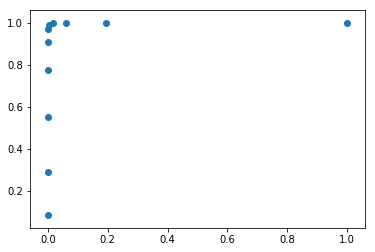

In [8]:
y_pred = m.predict_proba(X_train)[:,1]       
fpr,tpr,threhold = roc_curve(y_train, y_pred)
plt.scatter(fpr, tpr)

In [9]:
confusion_matrix(y_train, m.predict(X_train))

array([[154951,     16],
       [  1482,  15026]], dtype=int64)

In [11]:
tn, fp, fn, tp = confusion_matrix(y_train, m.predict(X_train)).ravel()
print(tn, fp, fn, tp)

154951 16 1482 15026


### 3.1b. train-test split, no subsampling

We split the dataset into training and testing dataset.
Training dadtaset is used to train the model
And testing dataset is used to evaluate the model.
For now, we still just use default parameters of random forest.

In [12]:
data_id = df.Unique_Client_ID
data_y = df.Gone
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Unique_Client_ID', 'Gone'],axis=1).values, data_y.values,\
                                                    test_size=0.2, random_state=66)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(137180, 80) (34295, 80) (137180,) (34295,)


In [13]:
m = RandomForestClassifier(n_jobs=-1, random_state=66)
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=66, verbose=0, warm_start=False)

In [14]:
print_score(m)

{'train_auc': 0.9997858501732007, 'test_auc': 0.85084608858558, 'train_score': 0.9913398454585216, 'test_score': 0.9082956699227293}


In [34]:
y_pred = m.predict_proba(X_test)[:,1]

In [35]:
confusion_matrix(y_test, m.predict(X_test))

array([[30533,   439],
       [ 2706,   617]], dtype=int64)

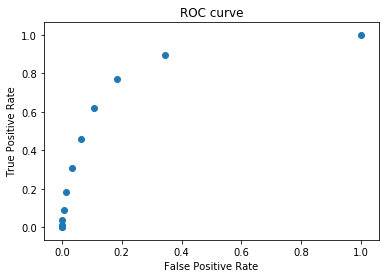

In [36]:
plotROC(y_test, y_pred)

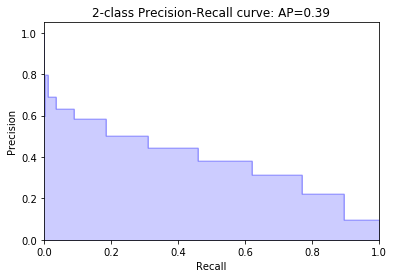

In [37]:
plotPRC1(y_test, y_pred)

### 3.1c. train-test split, subsampling

We build each tree based on a subset of whole dataset

### 3.2. XGBOOST <a id='part-32'>

In [2]:
# read the csv file for random forest from local
df = pd.read_csv('preprocessed_20180802_rf.csv')
data_y = df.Gone
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Unique_Client_ID', 'Gone'],axis=1).values, data_y.values,\
                                                    test_size=0.2, random_state=66)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(137180, 190) (34295, 190) (137180,) (34295,)


In [3]:
m = xgb.XGBClassifier(n_jobs = -1,
                      random_state=66,
                      max_depth=7,
                      subsample=0.9, colsample_bytree=0.9,
                      n_estimators=200,
                      #min_child_samples=20
                     )
# xgb_clf = xgb.XGBClassifier(n_jobs = -1, max_depth=6, eta=0.1, slient=1, objective='binary:logistic', 
#                            colsample_bytree=0.5, scale_pos_weight=2)

Wall time: 2h 50min 12s
AUC score:  0.9247340233996992


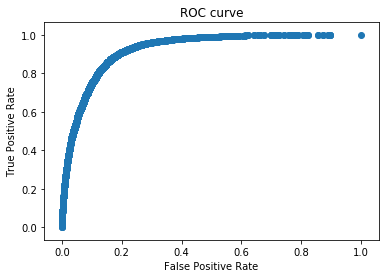

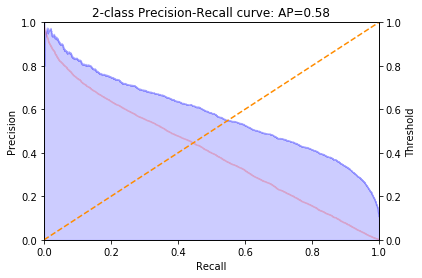

In [4]:
# native, train the model with all training data and predict on the test data
y_pred = np.zeros(len(y_test))
%time m.fit(X_train, y_train, eval_metric=['logloss', 'auc'],)
y_pred += m.predict_proba(X_test)[:, 1]
print('AUC score: ', roc_auc_score(y_test, y_pred))
plotROC(y_test, y_pred)
plotPRC1(y_test, y_pred)

In [5]:
save_obj(m, 'xgb20180802')

In [6]:
early_stopping_rounds = 50

Training on cycle-0............
Validation AUC score on cycle 0:  0.9220906815101342
Test AUC score on cycle 0:  0.9208056355951026
Training on cycle-1............
Validation AUC score on cycle 1:  0.9210771095627046
Test AUC score on cycle 1:  0.9198188250294238
Training on cycle-2............
Validation AUC score on cycle 2:  0.9214887544167583
Test AUC score on cycle 2:  0.9201761998421375
Training on cycle-3............
Validation AUC score on cycle 3:  0.9223556560464755
Test AUC score on cycle 3:  0.9209308639813255
Training on cycle-4............
Validation AUC score on cycle 4:  0.9217313877828786
Test AUC score on cycle 4:  0.9209386127215211
AUC score:  0.924747694217825


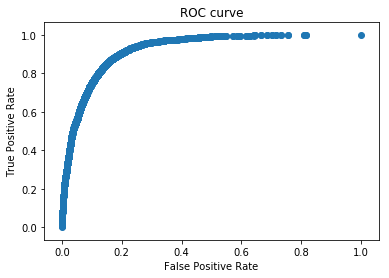

Wall time: 5h 44min 26s


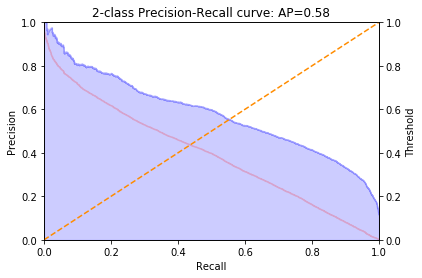

In [7]:
%%time
# k-fold (manually bagging approach, build each model based on 80% of training data)
num_fold = 5
y_pred = np.zeros(len(y_test))
skf = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=66)
for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train)):
    print(f'Training on cycle-{fold}............')
    X_train_kfold, X_valid = X_train[train_idx], X_train[valid_idx]
    y_train_kfold, y_valid = y_train[train_idx], y_train[valid_idx]
    m = xgb.XGBClassifier(n_jobs = -1,random_state=66,max_depth=7,subsample=0.4, colsample_bytree=0.4,n_estimators=10000,)#min_child_samples=20)
    m.fit(X_train_kfold, y_train_kfold, eval_metric=['logloss', 'auc'], eval_set=[(X_valid, y_valid)], early_stopping_rounds=early_stopping_rounds, verbose=False)
    y_pred += m.predict_proba(X_test)[:, 1]
    print(f'Validation AUC score on cycle {fold}: ', roc_auc_score(y_valid, m.predict_proba(X_valid)[:, 1]))
    print(f'Test AUC score on cycle {fold}: ', roc_auc_score(y_test, m.predict_proba(X_test)[:, 1]))

y_pred /= num_fold
print('AUC score: ', roc_auc_score(y_test, y_pred))
plotROC(y_test, y_pred)
plotPRC1(y_test, y_pred)

### 3.3. LightGBM <a id='part-33'>

In [3]:
# read the csv file for random forest from local
df = pd.read_pickle(f'{snapShotDate}_train.pickle')

In [4]:
# # select top 100 important features to train the model
# df = df[['Unique_Client_ID', 'Gone']+imp_cols[:100]]

In [22]:
data_y = df.Gone
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Unique_Client_ID', 'Gone'],axis=1).values, data_y.values,\
                                                    test_size=0.2, random_state=66)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(141779, 310) (35445, 310) (141779,) (35445,)


In [5]:
# %%time
# # Grid search to find the best hyper parameters
# y_pred = np.zeros(len(y_test))
# m_lgb = lgb.LGBMClassifier(n_jobs=-1, random_state=66,)
# param_grid = {
#     'max_depth': [6, 7],
#     'learning_rate': [0.01],
#     'n_estimators': [500],
#     'min_child_samples': [20],
#     'subsample': [0.5],
#     'colsample_bytree': [0.5],
# }

# m = GridSearchCV(m_lgb, param_grid, cv=5)

# m.fit(X_train, y_train)
# print('Best parameters found by grid search are:', m.best_params_)

# y_pred += m.predict_proba(X_test)[:, 1]
# print('AUC score: ', roc_auc_score(y_test, y_pred))
# plotROC(y_test, y_pred)
# plotPRC1(y_test, y_pred)

I manually did a grid search. It turns out that fitting each model can utilize most of the coputing resource. So it should not make a big difference if using the built-in grid search function.

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
        learning_rate=0.05, max_depth=8, min_child_samples=80,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=800,
        n_jobs=-1, num_leaves=63, objective=None, random_state=66,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.5,
        subsample_for_bin=200000, subsample_freq=0)
AUC score:  0.9296477342713465


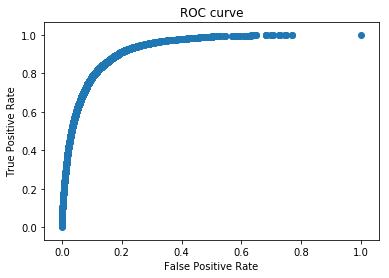

Wall time: 17h 3min 50s


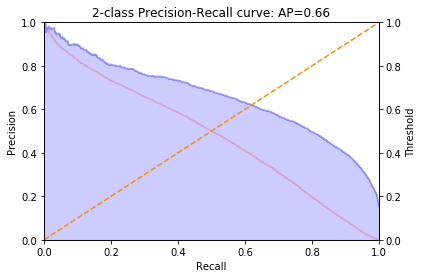

In [20]:
%%time
# manual grid search
param_grid = {
    'max_depth': [6, 7, 8],
    'learning_rate': [0.01, 0.03, 0.05],
    'n_estimators': [200, 500, 800],
    'min_child_samples': [20, 50, 80],
    'bagging_ratio': [0.3, 0.5, 0.8],
    'num_leaves': [24, 31, 63],
}

best_AUC = 0

for max_depth in param_grid['max_depth']:
    for learning_rate in param_grid['learning_rate']:
        for n_estimators in param_grid['n_estimators']:
            for min_child_samples in param_grid['min_child_samples']:
                for bagging_ratio in param_grid['bagging_ratio']:
                    for num_leaves in param_grid['num_leaves']:
                        m = lgb.LGBMClassifier(n_jobs=-1, random_state=66,
                                               learning_rate=learning_rate,
                                               max_depth=max_depth,
                                               num_leaves=num_leaves,
                                               subsample=bagging_ratio, colsample_bytree=bagging_ratio,
                                               n_estimators=n_estimators,
                                               min_child_samples=min_child_samples)
                        y_pred = np.zeros(len(y_test))
                        m.fit(X_train, y_train, eval_metric=['auc'],)
                        y_pred += m.predict_proba(X_test)[:, 1]
                        if roc_auc_score(y_test, y_pred) > best_AUC:
                            best_AUC = roc_auc_score(y_test, y_pred)
                            best_m = m
                        
print(best_m)
y_pred = np.zeros(len(y_test))
y_pred += best_m.predict_proba(X_test)[:, 1]
print('AUC score: ', roc_auc_score(y_test, y_pred))
plotROC(y_test, y_pred)
plotPRC1(y_test, y_pred)

In [22]:
save_obj(best_m, f'lgbm{snapShotDate}')

(Optional, you may want to stop here.) Build the model with the best set of parameters found above and train the model with all data instead of only the training data. This step is optional. I don't think it will make much difference.

In [23]:
m = lgb.LGBMClassifier(n_jobs=-1, random_state=66,
                       learning_rate=0.05,
                       max_depth=8,
                       subsample=0.5, colsample_bytree=0.5,
                       num_leaves = 63,
                       n_estimators=800,
                       min_child_samples=80)

Wall time: 1min 57s
AUC score:  0.9296977808669533


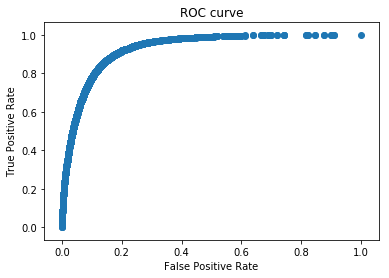

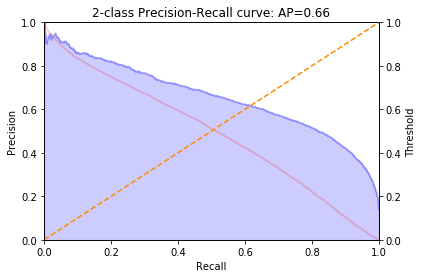

In [24]:
# native, train the model with all training data and predict on the test data
y_pred = np.zeros(len(y_test))
%time m.fit(X_train, y_train, eval_metric=['logloss', 'auc'],)
y_pred += m.predict_proba(X_test)[:, 1]
print('AUC score: ', roc_auc_score(y_test, y_pred))
plotROC(y_test, y_pred)
plotPRC1(y_test, y_pred)

In [25]:
save_obj(m, f'lgbm{snapShotDate}')

### 3.3. END ! The code below is only for the experimenting purpose. <a id='part-33end'>

Plot feature importances...


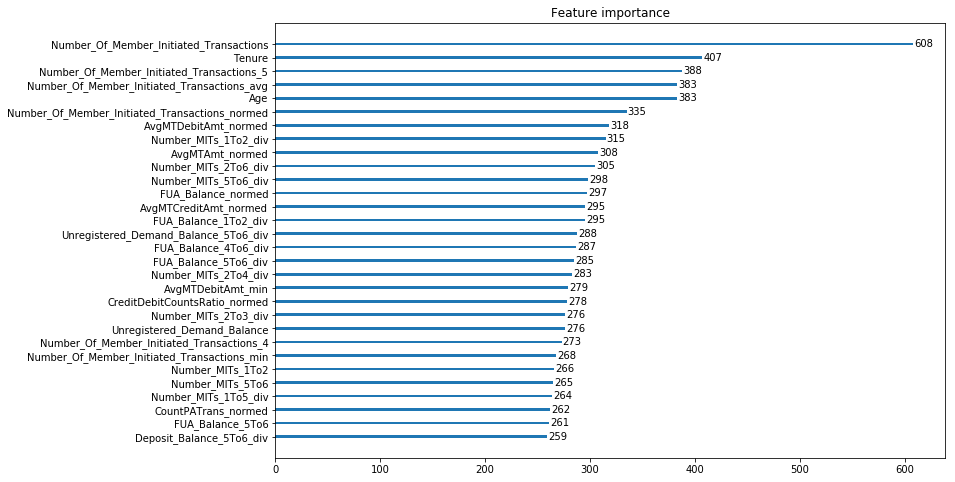

In [26]:
plotFI(m, df.columns[2:], max_num_features=30, importance_type='split')

In [27]:
imp_cols = [col for imp,col in sorted(zip(m.feature_importances_, df.columns[2:]),reverse=True)]

In [29]:
save_obj(imp_cols, f'imp_cols_{snapShotDate}')

**** NOTE: The souce code of lightgbm.plotting has been modified. The original source code file (plotting_original.py) is still in the folder. If you want to use the original one, simple change the name of it back to plotting.py ****

In [15]:
print('Plot 84th tree...')  # one tree use categorical feature to split
ax = lgb.plot_tree(m.booster_, tree_index=83, figsize=(100, 50), show_info=['split_gain'], feature_names = df.columns[2:])
plt.show()

In [19]:
print('Plot 84th tree with graphviz...')
graph = lgb.create_tree_digraph(m.booster_, tree_index=83, name='Tree84', feature_names=df.columns[2:])
graph.render(view=True)

Plot 84th tree with graphviz...


'Tree84.gv.pdf'

In [9]:
early_stopping_rounds = 500
# lgb_clf = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=7, max_depth=4, learning_rate=0.05, n_estimators=100, 
#                              subsample_for_bin=200000, objective='binary', class_weight=None, 
#                              min_split_gain=0.0, min_child_weight=0, 
#                              min_child_samples=20, subsample=0.9, 
#                              subsample_freq=1, colsample_bytree=0.7, 
#                              reg_alpha=0.0, reg_lambda=0.0, random_state=66, n_jobs=-1,
#                              max_bin=100, verbose=0, scale_pos_weight=150, metric='auc', nthread=4)

Here I did a k-fold cross validation. From the result we can see that the model works equally on training folds and validation fold. So the model trained with only the training folds should work as well as the model trained with all folds.

In [10]:
%%time
# k-fold (manually bagging approach, build each model based on 80% of training data)
num_fold = 5
y_pred = np.zeros(len(y_test))
skf = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=66)
for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train)):
    print(f'Training on cycle-{fold}............')
    X_train_kfold, X_valid = X_train[train_idx], X_train[valid_idx]
    y_train_kfold, y_valid = y_train[train_idx], y_train[valid_idx]
    m = lgb.LGBMClassifier(n_jobs=-1, random_state=66, max_depth=7,
                           subsample=0.4, colsample_bytree=0.4,
                           n_estimators=10000, min_child_samples=20)
    m.fit(X_train_kfold, y_train_kfold,\
          eval_metric=['auc', 'logloss'], eval_set=[(X_valid, y_valid)],\
          early_stopping_rounds=early_stopping_rounds, verbose=False)
    y_pred += m.predict_proba(X_test)[:, 1]
    print(f'Validation AUC score on cycle {fold}: ', roc_auc_score(y_valid, m.predict_proba(X_valid)[:, 1]))
    print(f'Test AUC score on cycle {fold}: ', roc_auc_score(y_test, m.predict_proba(X_test)[:, 1]))
y_pred /= num_fold

Training on cycle-0............
Validation AUC score on cycle 0:  0.92332790218109
Test AUC score on cycle 0:  0.9225483831337822
Training on cycle-1............
Validation AUC score on cycle 1:  0.9224326650356848
Test AUC score on cycle 1:  0.9231933309415717
Training on cycle-2............
Validation AUC score on cycle 2:  0.9234060580476205
Test AUC score on cycle 2:  0.9226139875147245
Training on cycle-3............
Validation AUC score on cycle 3:  0.9235806433593363
Test AUC score on cycle 3:  0.9237049129713969
Training on cycle-4............
Validation AUC score on cycle 4:  0.9237182533462095
Test AUC score on cycle 4:  0.9232185349943213
Wall time: 7min 31s


AUC score:  0.9262508040714669


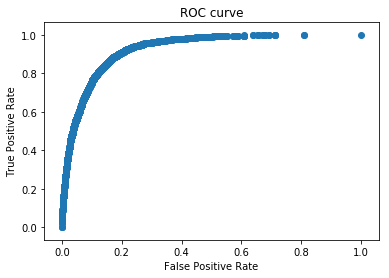

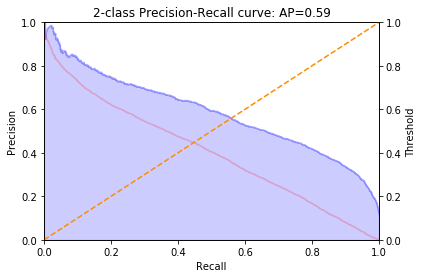

In [11]:
print('AUC score: ', roc_auc_score(y_test, y_pred))
plotROC(y_test, y_pred)
plotPRC1(y_test, y_pred)

In [25]:
y_pred_label = (y_pred>=0.30).astype(np.int)
confusion_matrix(y_test, y_pred_label)

array([[28975,  1997],
       [ 1218,  2105]], dtype=int64)

In [32]:
# train on whole training dataset and save the models onto the disk
y_train = df.Gone.values
X_train = df.drop(['Unique_Client_ID', 'Gone'], axis=1).values
# k-fold (manually bagging approach, build each model based on 80% of training data)
num_fold = 5
skf = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=66)
for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train)):
    print(f'Training on cycle-{fold}............')
    X_train_kfold, X_valid = X_train[train_idx], X_train[valid_idx]
    y_train_kfold, y_valid = y_train[train_idx], y_train[valid_idx]
    m = lgb.LGBMClassifier(n_jobs=-1, random_state=66,
                       max_depth=7,
                       subsample=0.4, colsample_bytree=0.4,
                       n_estimators=10000,
                       min_child_samples=20)
    early_stopping_rounds = 500
    m.fit(X_train_kfold, y_train_kfold,\
          eval_metric=['auc', 'logloss'], eval_set=[(X_valid, y_valid)],\
          early_stopping_rounds=early_stopping_rounds, verbose=False)
    save_obj(m, f'lgbm20180727_fold{fold}')
    print(f'Validation AUC score on cycle {fold}: ', roc_auc_score(y_valid, m.predict_proba(X_valid)[:, 1]))

Training on cycle-0............
Validation AUC score on cycle 0:  0.9211625219503807
Training on cycle-1............
Validation AUC score on cycle 1:  0.9219431286733875
Training on cycle-2............
Validation AUC score on cycle 2:  0.9267561794643729
Training on cycle-3............
Validation AUC score on cycle 3:  0.9256273316077381
Training on cycle-4............
Validation AUC score on cycle 4:  0.9251339874627267


### 3.4. Neural network <a id='part-34'>

In [48]:
df = pd.read_csv('preprocessed_20180725_nn.csv')
# this might need to be changed
df = df.fillna(-1)
data_y = df.Gone
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Unique_Client_ID', 'Gone'],axis=1).values, data_y.values,\
                                                    test_size=0.2, random_state=66)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(137134, 210) (34284, 210) (137134,) (34284,)


### 3.4a. Sklearn multi-layer perceptron <a id='part-34a'>

In [79]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 2), random_state=66)

In [80]:
%time clf.fit(X_train, y_train)

Wall time: 2min 41s


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=66, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

AUC score:  0.8852649528921291


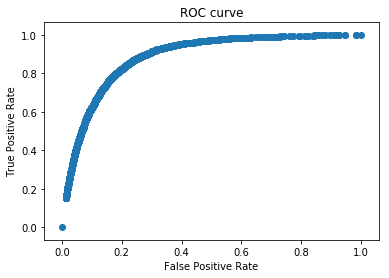

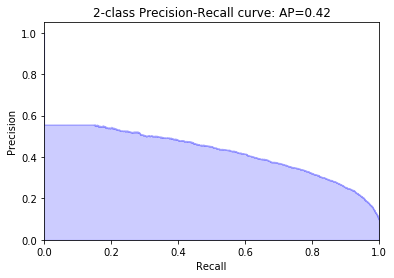

In [81]:
y_pred = clf.predict_proba(X_test)[:,1]
print('AUC score: ', roc_auc_score(y_test, y_pred))
plotROC(y_test, y_pred)
plotPRC1(y_test, y_pred)

### 3.4(b). Neural network with Keras <a id='part-34b'>

In [66]:
import keras
from keras.utils import *
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

In [68]:
model = Sequential()
model.add(Dense(units=200, activation='relu', input_dim=80))
model.add(Dropout(0.5))
model.add(Dense(units=100, activation='relu', input_dim=100))
model.add(Dropout(0.5))
model.add(Dense(units=100, activation='relu', input_dim=100))
model.add(Dropout(0.5))
model.add(Dense(units=2, activation='sigmoid'))

In [69]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True),
              #metrics=[]
             )

In [70]:
%time model.fit(X_train, to_categorical(y_train),\
                epochs=30, batch_size=32,)
                #validation_split=0.1,)

Epoch 1/30
137180/137180 [==============================] - 27s 200us/step - loss: 0.2637
Epoch 2/30
137180/137180 [==============================] - 21s 149us/step - loss: 0.2416
Epoch 3/30
137180/137180 [==============================] - 20s 142us/step - loss: 0.2353
Epoch 4/30
137180/137180 [==============================] - 18s 132us/step - loss: 0.2323
Epoch 5/30
137180/137180 [==============================] - 15s 110us/step - loss: 0.2301
Epoch 6/30
137180/137180 [==============================] - 15s 110us/step - loss: 0.2279
Epoch 7/30
137180/137180 [==============================] - 15s 110us/step - loss: 0.2256
Epoch 8/30
137180/137180 [==============================] - 15s 109us/step - loss: 0.2243
Epoch 9/30
137180/137180 [==============================] - 15s 112us/step - loss: 0.2234
Epoch 10/30
137180/137180 [==============================] - 15s 113us/step - loss: 0.2223
Epoch 11/30
137180/137180 [==============================] - 15s 111us/step - loss: 0.2219
Epoch 12

AUC score:  0.8927508820543998


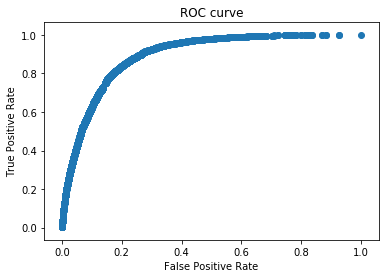

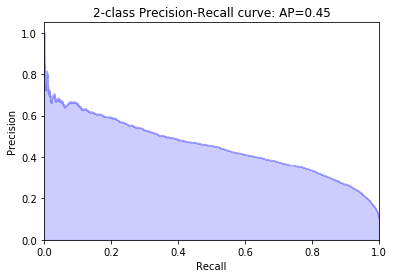

In [71]:
y_pred = model.predict_proba(X_test)[:,1]
print('AUC score: ', roc_auc_score(y_test, y_pred))
plotROC(y_test, y_pred)
plotPRC1(y_test, y_pred)

### 3.4c. autoencoding with Keras, then feed the encoded data into tree emsembling based model <a id='part-34c'>

Todo. I didn't try this one. Some kagglers applied this method to classification problem and it works well.

### 3.5. Logistic regression <a id='part-35'>

In [2]:
df = pd.read_csv('preprocessed_20180725_nn.csv')
# this might need to be changed
df = df.fillna(-1)
data_id = df.Unique_Client_ID
data_y = df.Gone
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Unique_Client_ID', 'Gone'],axis=1).values, data_y.values,\
                                                    test_size=0.2, random_state=66)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(137134, 210) (34284, 210) (137134,) (34284,)


In [3]:
clf = LogisticRegression(solver='lbfgs', random_state=66)

In [4]:
%time clf.fit(X_train, y_train)

Wall time: 7.45 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=66, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

AUC score:  0.8730613893934956


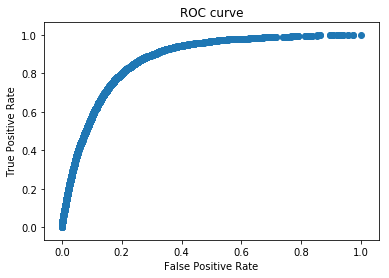

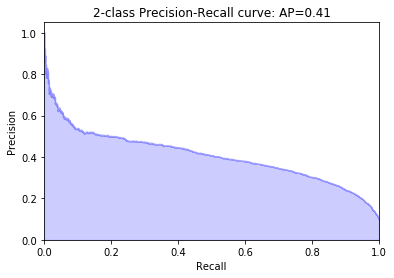

In [5]:
y_pred = clf.predict_proba(X_test)[:,1]
print('AUC score: ', roc_auc_score(y_test, y_pred))
plotROC(y_test, y_pred)
plotPRC1(y_test, y_pred)

### 3.6. Ensemble different models <a id='part-36'>

In [ ]:
# read the csv file for random forest from local
df = pd.read_csv('preprocessed_20180727_rf.csv')

data_y = df.Gone
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Unique_Client_ID', 'Gone'],axis=1).values, data_y.values,\
                                                    test_size=0.2, random_state=66)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

### 3.6a. Vote between lgb model and xgboost model 

In [10]:
m_lgb = load_obj('lgbm20180727')
m_xgb = load_obj('xgb20180801')

AUC score:  0.9257189149983703


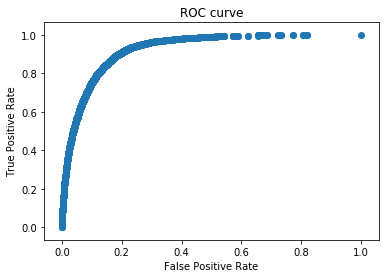

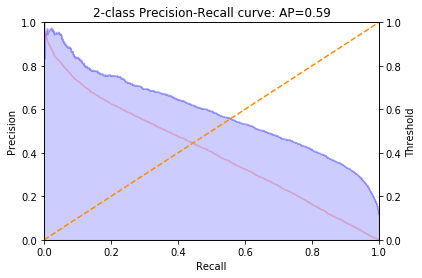

In [11]:
y_pred_lgb = m_lgb.predict_proba(X_test)[:,1]
y_pred_xgb = m_xgb.predict_proba(X_test)[:,1]
y_pred = (y_pred_lgb + y_pred_xgb) / 2
print('AUC score: ', roc_auc_score(y_test, y_pred))
plotROC(y_test, y_pred)
plotPRC1(y_test, y_pred)

### 3.6b. Vote between lgb model and nn

In [72]:
y_pred_nn = y_pred.copy()

In [76]:
y_pred_lgb = y_pred.copy()

AUC score:  0.9121585322092444


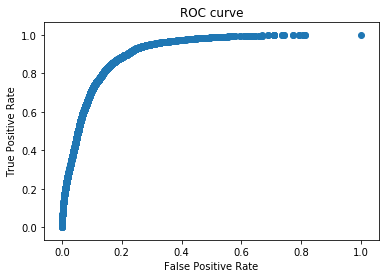

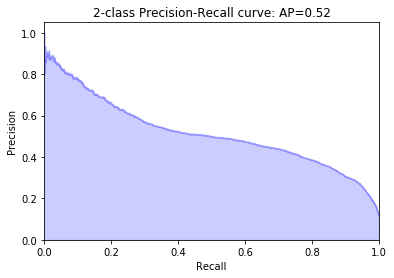

In [77]:
y_pred = (y_pred_nn+y_pred_lgb)/2
print('AUC score: ', roc_auc_score(y_test, y_pred))
plotROC(y_test, y_pred)
plotPRC1(y_test, y_pred)

## Contributors <a id='part-4'>

- Guillaume Colley (Data Science manager)
    - Provide guidlines of building the model.
- Yabin Guo (hired as a data scientist intern by Vancity from May 2018 to December 2018)
    - Write the python code for this member retentioni model.
    - Update the SQL scripts to retrieve the data from data warehouse.
- Wei Yuen Wu (SFU researcher)
    - Provide valued suggestions on building the model.
- Suchita Venugopal (hired as a data scientist intern by Vancity from May 2017 to April 2018)
    - Write the R code for this member retentioni model.
    - Write the SQL scripts to retrieve the data from data warehouse.